Daniel Rocha Ruiz, MSc in Data Science and Business Analytics

Source:
- https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/

# Set-up
## Import packages

In [1]:
# general
import pandas as pd
import numpy as np
from datetime import datetime

# viz
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.arima.model import ARIMA

## Load data
The data contains a particular month and number of passengers travelling in that month. In order to read the data as a time series, we have to pass special arguments to the read_csv command:

In [2]:
dateparse = lambda dates: datetime.strptime(dates, '%Y-%m')
dateparse = lambda dates: datetime.strptime(dates, '%Y-%m')
data = pd.read_csv('../data/AirPassengers.csv', parse_dates=['Month'], index_col='Month',date_parser=dateparse)
data.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


# Exploratory Data Analysis
## Data Formatting

In [3]:
# create a pandas series object
ts = data['#Passengers']

# you can call obs from the series in two different ways:
print(ts['1949-01-01']) # as a string
print(ts[datetime(1949,1,1)]) # as a datetime

112
112


## Stationarity
Stationarity requires:
- Constant mean
- Constant variance and
- Time-independent auto-covariance.

In [4]:
def test_stationarity(timeseries):
    
    # rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    # plot
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # adf
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
               
    print(dfoutput)
    
    if dfoutput['p-value']>0.05:
        print("The p-value is greater than 0.05.")
        print ("Hence, it fails to reject the null hypothesis that the time series is non-stationary.")
        print("This is evidence that the time series is non-stationary.")
    else:
        print("The p-value is not greater than 0.05.")
        print ("Hence, it rejects the null hypothesis that the time series is non-stationary.")
        print("This is evidence that the time series is stationary.") 

### Original Series

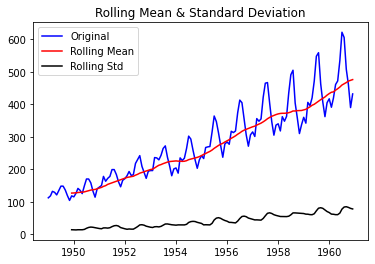

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64
The p-value is greater than 0.05.
Hence, it fails to reject the null hypothesis that the time series is non-stationary.
This is evidence that the time series is non-stationary.


In [5]:
test_stationarity(ts)

### Log

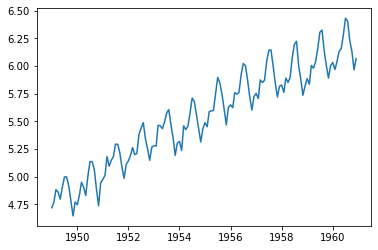

In [6]:
ts_log = np.log(ts)
plt.plot(ts_log)
plt.show()

### Moving Average of Log

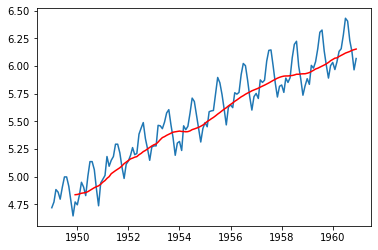

In [7]:
moving_avg = ts_log.rolling(12).mean()

# plot
plt.plot(ts_log)
plt.plot(moving_avg, color='red')
plt.show()

### Log minus its Moving Average

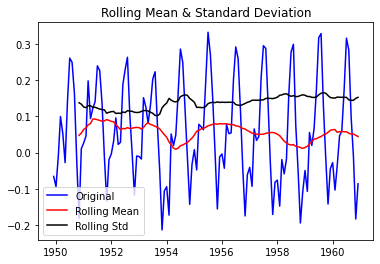

Results of Dickey-Fuller Test:
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64
The p-value is not greater than 0.05.
Hence, it rejects the null hypothesis that the time series is non-stationary.
This is evidence that the time series is stationary.


In [8]:
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.dropna(inplace=True)

test_stationarity(ts_log_moving_avg_diff)

### Exponential Moving Average of the Log

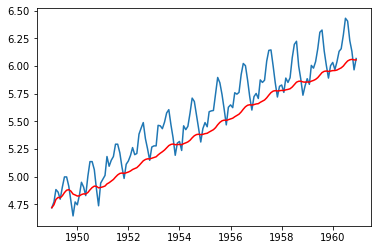

In [9]:
expwighted_avg = ts_log.ewm(halflife=12).mean()

# plot
plt.plot(ts_log)
plt.plot(expwighted_avg, color='red')
plt.show()

### Exponential Moving Average of the Log minus its Moving Average

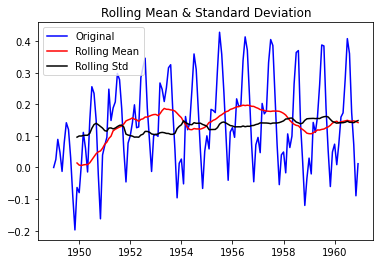

Results of Dickey-Fuller Test:
Test Statistic                  -3.601262
p-value                          0.005737
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64
The p-value is not greater than 0.05.
Hence, it rejects the null hypothesis that the time series is non-stationary.
This is evidence that the time series is stationary.


In [10]:
ts_log_ewma_diff = ts_log - expwighted_avg
test_stationarity(ts_log_ewma_diff)

### First Difference

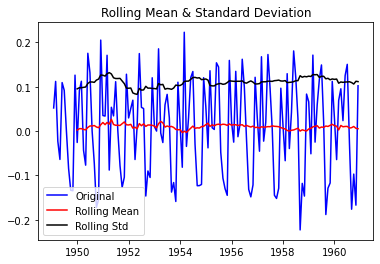

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64
The p-value is greater than 0.05.
Hence, it fails to reject the null hypothesis that the time series is non-stationary.
This is evidence that the time series is non-stationary.


In [11]:
ts_log_diff = ts_log - ts_log.shift()
ts_log_diff.dropna(inplace=True) # drop first obs
test_stationarity(ts_log_diff)

## Seasonality

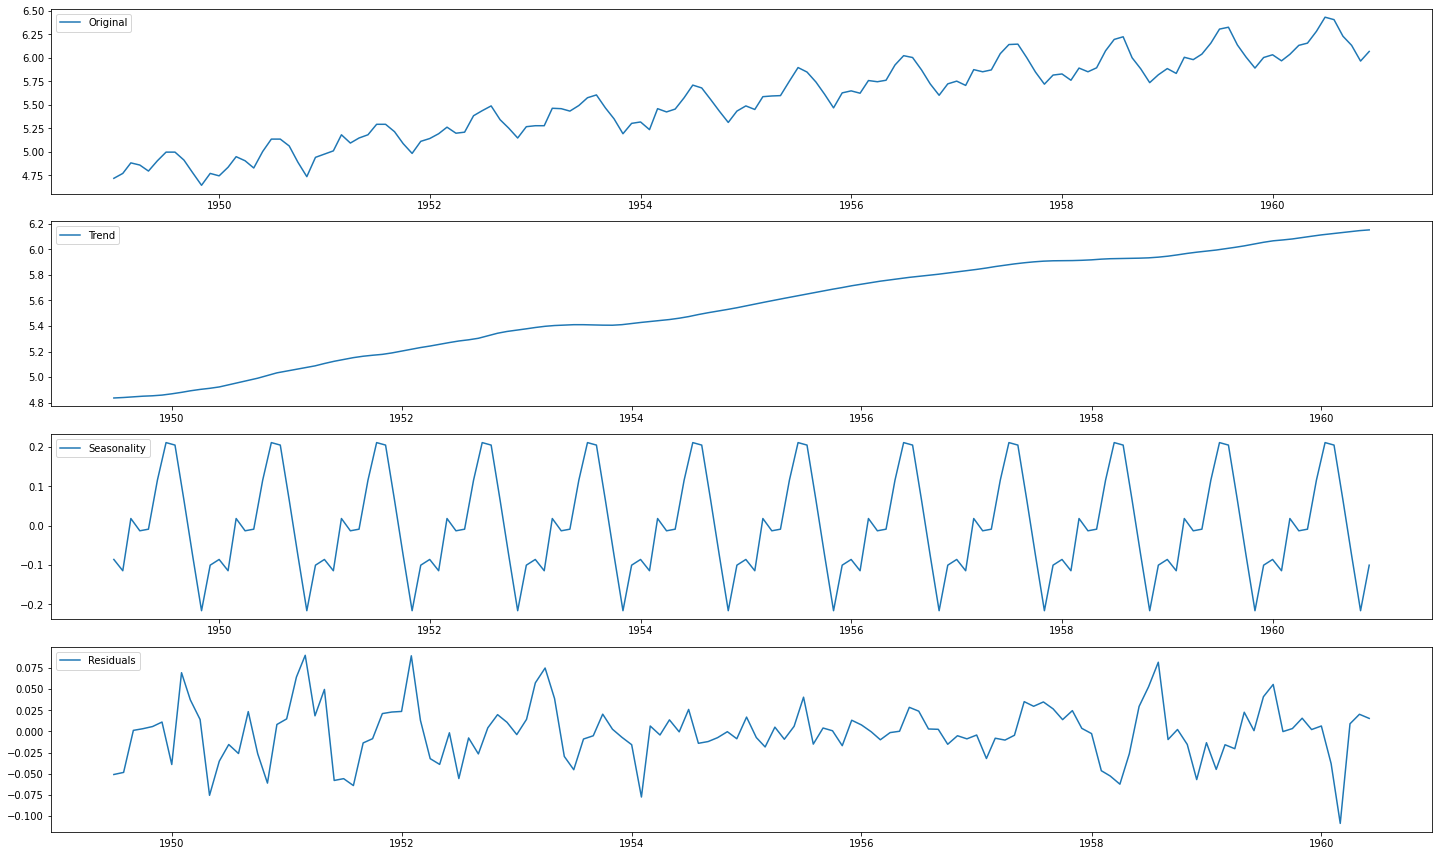

In [12]:
# decompose
decomposition = seasonal_decompose(ts_log)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# plot
# original
plt.figure(figsize=(20, 12))
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='upper left')
# treng
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='upper left')
plt.subplot(413)
# seasonality
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='upper left')
plt.subplot(414)
# residuals
plt.plot(residual, label='Residuals')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

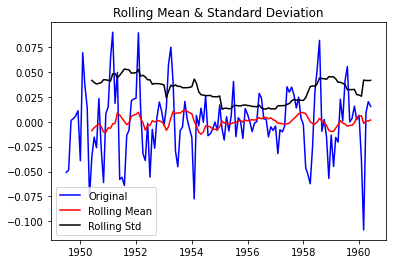

Results of Dickey-Fuller Test:
Test Statistic                -6.332387e+00
p-value                        2.885059e-08
#Lags Used                     9.000000e+00
Number of Observations Used    1.220000e+02
Critical Value (1%)           -3.485122e+00
Critical Value (5%)           -2.885538e+00
Critical Value (10%)          -2.579569e+00
dtype: float64
The p-value is not greater than 0.05.
Hence, it rejects the null hypothesis that the time series is non-stationary.
This is evidence that the time series is stationary.


In [13]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True) # drop first obs
test_stationarity(ts_log_decompose)

## ACF and PACF

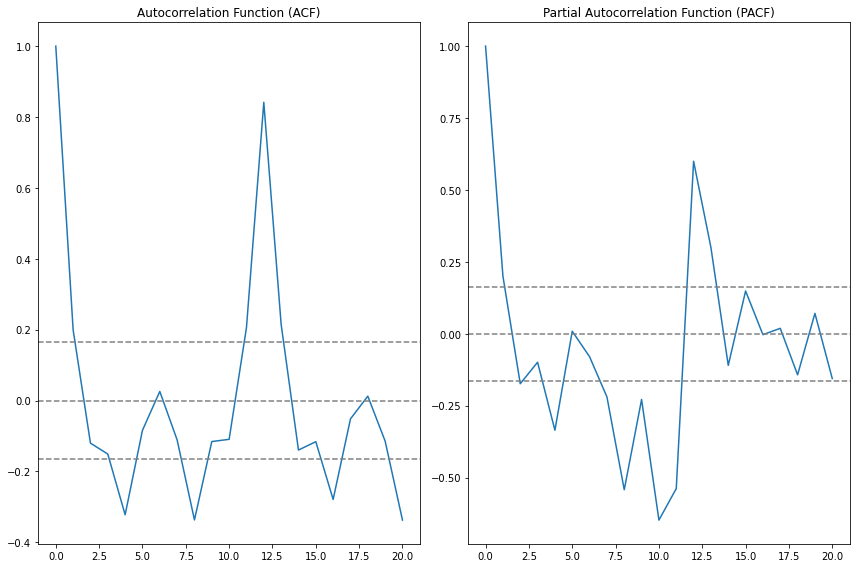

In [14]:
# calculate
lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

# plot ACF: 
plt.figure(figsize=(12, 8))
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function (ACF)')

# Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function (PACF)')
plt.tight_layout()

plt.show()

# Modelling
## DPlot function

In [15]:
def arima_plot(order,series):
    
    # create model
    model = ARIMA(series
                  ,order=order
                  ,freq="MS"
                 )
    results = model.fit()

    # plot
    plt.figure(figsize=(12, 8))
    plt.plot(series.index
             ,series.values
             ,color="blue"
             ,label="actual"
            )
    # the reason for doing this shift(-adj) is not clear!
    adj = max(max(results.specification.order)-1,0)
    plt.plot(results.fittedvalues.shift(-adj).index
             ,results.fittedvalues.shift(-adj).values
             ,color='red'
             ,label="predicted"
            )

    plt.title("ARIMA {} with MSE {:.2f}".format(results.specification.order, results.mse))
    plt.legend()
    plt.show()

## AR

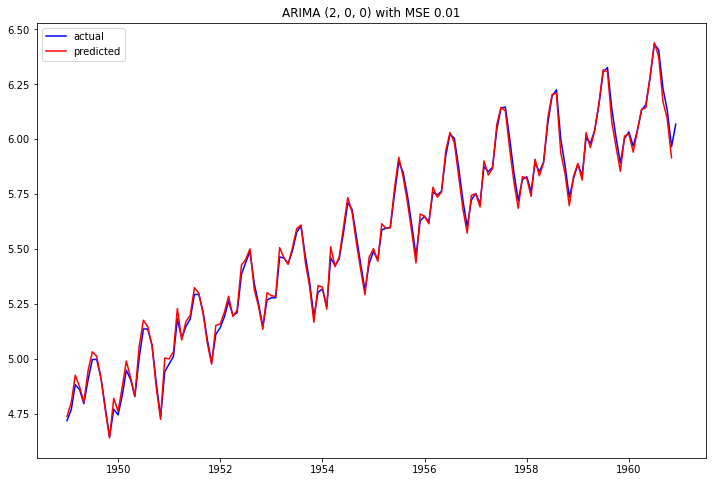

In [16]:
# AR
order=(2,0,0)
series=ts_log
series.index.freq = 'MS'

# plot
arima_plot(order,series)

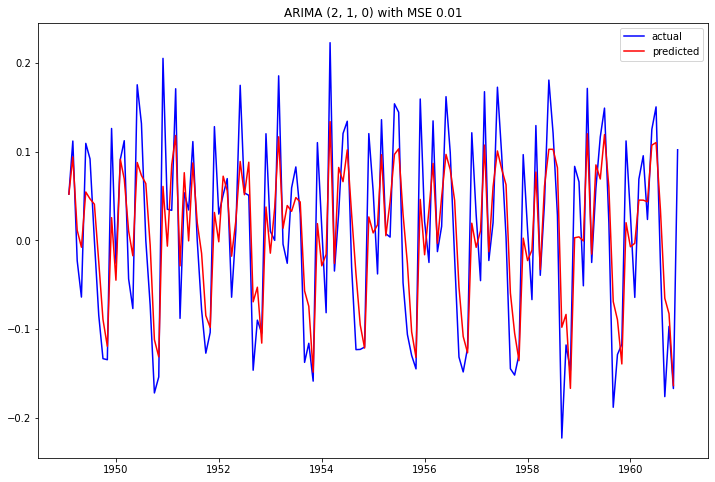

In [17]:
# AR of log diff
order=(2,1,0)
series=ts_log_diff
series.index.freq = 'MS'

arima_plot(order,series)

## MA

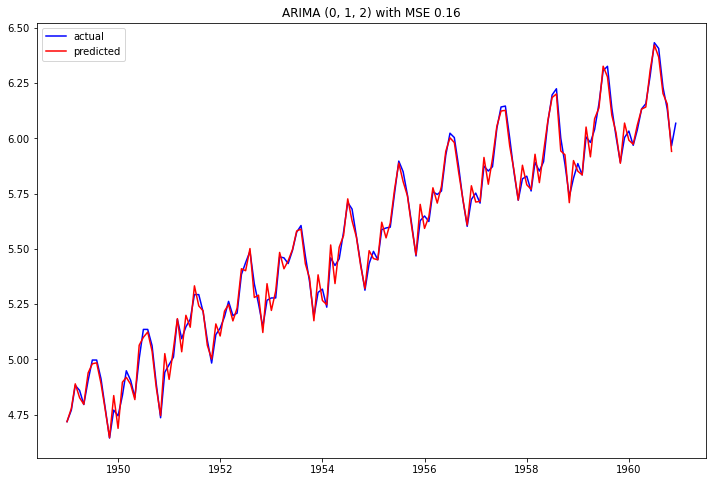

In [18]:
# MA
order=(0,1,2)
series=ts_log
series.index.freq = 'MS'

# plot
arima_plot(order,series)

## ARMA

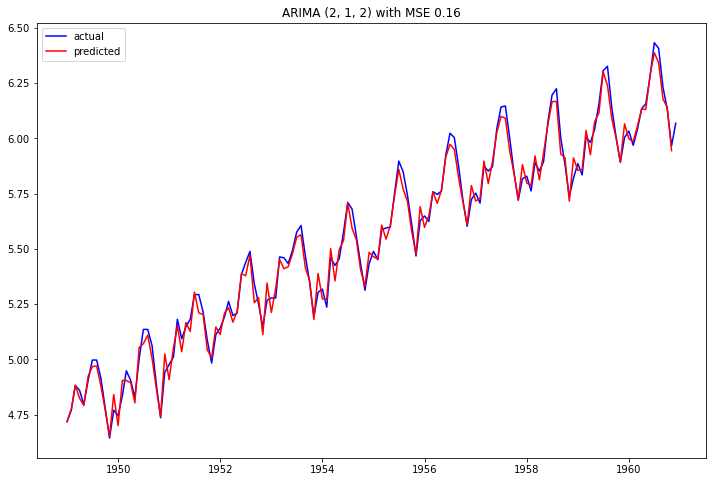

In [19]:
# ARMA
order=(2,1,2)
series=ts_log
series.index.freq = 'MS'

# plot
arima_plot(order,series)